<h1 style="font-size:32px; font-weight:700; margin-bottom:10px;"> 👁️ MegaTruth: Fine-Tuning CLIP para Detecção de IA</h1>

<h2 style="font-size:24px; margin-top:20px;"> 🎯 Objetivo</h2>
<p style="font-size:16px; line-height:1.6;">
Treinar um modelo <b>CLIP (ViT-B/16)</b> capaz de distinguir imagens Reais de imagens geradas por IA com alta robustez.
<br>Diferente de detectores comuns, este modelo utiliza uma estratégia <b>Generalista</b> para evitar o viés de textura.
</p>

<h2 style="font-size:22px; margin-top:20px;"> 🧪 A Estratégia "Frankenstein" + Low-Res</h2>
<p style="font-size:16px; line-height:1.6;">
Para cobrir todas as falhas das IAs, combinamos 4 datasets distintos e aplicamos uma técnica de Data Augmentation:
<ul>
    <li><b>Mix de Dados (200k):</b> Artifact (Texturas e variação), CIFAKE (Baixa Resolução), 140k Faces (Anatomia) e GenImage (Lógica/DALL-E).</li>
    <li><b>Low-Res Augmentation:</b> 50% das imagens de treino são redimensionadas para baixa resolução (128px) propositalmente. Isso força o modelo a aprender <b>Forma e Anatomia</b> em vez de depender apenas de ruídos de pixel invisíveis.</li>
</ul>
</p>

<h2 style="font-size:22px; margin-top:20px;"> 📂 Saída</h2>
<ul>
    <li>Modelo Fine-Tuned salvo em <code>checkpoints/</code></li>
    <li>Pacote de Validação (Imagens + CSV) para testes locais.</li>
</ul>

<hr style="margin:20px 0;">

# **Instalação das dependências**

In [1]:
# Se estiver no Kaggle, geralmente já tem tudo, mas por garantia:
!pip install transformers torch pillow pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

# **Imports**

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPConfig
import torch.optim as optim
from tqdm import tqdm

# Configuração de dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

2025-12-04 21:22:58.436620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764883378.630464      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764883378.687541      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Usando dispositivo: cuda


# **Carregamento dos dados dos 4 datasets**

In [15]:
import os
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

# --- CONFIGURAÇÕES ---
TARGET_TOTAL = 200000 # Meta de imagens (50k de cada fonte)
VAL_SIZE = 0.1
SEED = 42

# --- FUNÇÃO DE BUSCA INTELIGENTE ---
def find_images_robust(base_path, keywords):
    """
    Procura imagens (jpg, png) em qualquer subpasta que contenha
    uma das palavras-chave (ex: 'fake', 'ai', 'synthetic').
    """
    found_images = []
    if not os.path.exists(base_path):
        return []
    
    print(f"   Procurando em '{base_path}' por {keywords}...")
    
    for root, dirs, files in os.walk(base_path):
        # Verifica se o nome da pasta bate com alguma palavra-chave
        folder_name = os.path.basename(root).lower()
        if any(kw.lower() in folder_name for kw in keywords):
            # Pega as imagens dessa pasta
            imgs = glob.glob(os.path.join(root, "*.jpg")) + \
                   glob.glob(os.path.join(root, "*.png")) + \
                   glob.glob(os.path.join(root, "*.jpeg"))
            found_images.extend(imgs)
            if len(imgs) > 0:
                print(f"   -> Achei {len(imgs)} imagens na pasta: {folder_name}")
                
    return found_images

print("🍳 Cozinhando o Dataset 'Frankenstein' (Blindado)...")

# ---------------------------------------------------------
# 1. ARTIFACT (Texturas e Diversidade)
# ---------------------------------------------------------
print("\n1. Carregando Artifact...")
metadata_list = []
artifact_dir = '/kaggle/input/artifact-dataset'

if os.path.exists(artifact_dir):
    for folder in tqdm(os.listdir(artifact_dir)):
        full_folder = os.path.join(artifact_dir, folder)
        if os.path.isdir(full_folder):
            csv_path = os.path.join(full_folder, 'metadata.csv')
            if os.path.exists(csv_path):
                try:
                    t_df = pd.read_csv(csv_path)
                    t_df['base_dir'] = full_folder
                    t_df['full_path'] = t_df['base_dir'] + '/' + t_df['image_path'].astype(str)
                    # 0=Real, 1=Fake
                    t_df['target'] = pd.to_numeric(t_df['target'], errors='coerce').fillna(1).astype(int)
                    t_df['target'] = np.where(t_df['target'] == 0, 0, 1)
                    
                    t_df['source_folder'] = folder # Para estratificação
                    metadata_list.append(t_df[['full_path', 'target', 'source_folder']])
                except: pass

if metadata_list:
    df_full_art = pd.concat(metadata_list)
    
    # Amostragem Estratificada por pasta (Garante variedade)
    def get_stratified(df, n):
        return df.groupby('source_folder', group_keys=False).apply(
            lambda x: x.sample(frac=min(1.0, n/len(df)+0.01), random_state=SEED)
        ).sample(n=min(len(df), n), random_state=SEED)

    df_art_real = get_stratified(df_full_art[df_full_art['target']==0], 25000)
    df_art_fake = get_stratified(df_full_art[df_full_art['target']==1], 25000)
    
    df_artifact = pd.concat([df_art_real, df_art_fake])
    print(f"   -> Artifact OK: {len(df_artifact)} imagens")
else:
    print("⚠️ Artifact não encontrado!")
    df_artifact = pd.DataFrame()

# ---------------------------------------------------------
# 2. CIFAKE (Baixa Resolução - Birdy654)
# ---------------------------------------------------------
print("\n2. Carregando CIFAKE...")
cifake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'

# Palavras-chave para encontrar as pastas certas
cf_real = find_images_robust(cifake_dir, ['real'])
cf_fake = find_images_robust(cifake_dir, ['fake'])

df_cifake = pd.DataFrame({
    'full_path': cf_real[:25000] + cf_fake[:25000],
    'target': [0]*len(cf_real[:25000]) + [1]*len(cf_fake[:25000])
})

# ---------------------------------------------------------
# 3. 140k FACES (Especialista em Rosto)
# ---------------------------------------------------------
print("\n3. Carregando 140k Faces...")
faces_dir = '/kaggle/input/140k-real-and-fake-faces'

fc_real = find_images_robust(faces_dir, ['real'])
fc_fake = find_images_robust(faces_dir, ['fake'])

df_faces = pd.DataFrame({
    'full_path': fc_real[:25000] + fc_fake[:25000],
    'target': [0]*len(fc_real[:25000]) + [1]*len(fc_fake[:25000])
})

# ---------------------------------------------------------
# 4. TRISTAN ZHANG (AI vs Real - Moderno)
# ---------------------------------------------------------
print("\n4. Carregando TristanZhang (AI vs Real)...")
zhang_dir = '/kaggle/input/ai-generated-images-vs-real-images'

# Aqui está a correção: Procura por 'real' E por 'aiart'/'fake'
zg_real = find_images_robust(zhang_dir, ['real'])
zg_fake = find_images_robust(zhang_dir, ['fake', 'aiart', 'synthetic'])

# Balancear
n_zg = min(len(zg_real), len(zg_fake))
df_zhang = pd.DataFrame({
    'full_path': zg_real[:n_zg] + zg_fake[:n_zg],
    'target': [0]*n_zg + [1]*n_zg
})

# ---------------------------------------------------------
# CONSOLIDAÇÃO
# ---------------------------------------------------------
print("\n Misturando tudo...")
df_final = pd.concat([df_artifact, df_cifake, df_faces, df_zhang], ignore_index=True)
df_final = shuffle(df_final, random_state=SEED).reset_index(drop=True)

# Legenda para o CLIP
df_final['caption'] = np.where(df_final['target'] == 0, "a real photograph", "an AI-generated image")

print("="*50)
print(f"✅ DATASET FINAL PRONTO: {len(df_final)} imagens")
print(f"   Distribuição: {df_final['target'].value_counts().to_dict()} (0=Real, 1=Fake)")
print("="*50)

# Salvar
train_df, val_df = train_test_split(df_final, test_size=VAL_SIZE, random_state=SEED, stratify=df_final['target'])
val_df.to_csv("validation_set_mixed.csv", index=False)
train_df.to_csv("training_set_mixed.csv", index=False)
print("💾 Arquivos salvos. Pode iniciar o treino!")

🍳 Cozinhando o Dataset 'Frankenstein' (Blindado)...

1. Carregando Artifact...


  0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipykernel_47/1595549495.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('source_folder', group_keys=False).apply(
/tmp/ipykernel_47/1595549495.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('source_folder', group_keys=False).apply(


   -> Artifact OK: 50000 imagens

2. Carregando CIFAKE...
   Procurando em '/kaggle/input/cifake-real-and-ai-generated-synthetic-images' por ['real']...
   -> Achei 10000 imagens na pasta: real
   -> Achei 50000 imagens na pasta: real
   Procurando em '/kaggle/input/cifake-real-and-ai-generated-synthetic-images' por ['fake']...
   -> Achei 10000 imagens na pasta: fake
   -> Achei 50000 imagens na pasta: fake

3. Carregando 140k Faces...
   Procurando em '/kaggle/input/140k-real-and-fake-faces' por ['real']...
   -> Achei 10000 imagens na pasta: real
   -> Achei 10000 imagens na pasta: real
   -> Achei 50000 imagens na pasta: real
   Procurando em '/kaggle/input/140k-real-and-fake-faces' por ['fake']...
   -> Achei 10000 imagens na pasta: fake
   -> Achei 10000 imagens na pasta: fake
   -> Achei 50000 imagens na pasta: fake

4. Carregando TristanZhang (AI vs Real)...
   Procurando em '/kaggle/input/ai-generated-images-vs-real-images' por ['real']...
   -> Achei 6000 imagens na pasta: re

# **Definição da Classe Dataset (RobustCLIPDataset)**

In [17]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import random

class RobustCLIPDataset(Dataset):
    def __init__(self, dataframe, processor, aug_prob=0.5):
        self.dataframe = dataframe
        self.processor = processor
        self.aug_prob = aug_prob # 50% de chance de simular baixa qualidade
        self.low_res_size = (128, 128) # Tamanho "ruim" para forçar aprendizado de forma

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if idx >= len(self.dataframe): idx = idx % len(self.dataframe)
        row = self.dataframe.iloc[idx]
        
        try:
            image = Image.open(row['full_path']).convert("RGB")
            
            # --- LÓGICA HÍBRIDA ---
            # Joga a moeda: Se cair 'cara', estraga a imagem para forçar o modelo a ver anatomia
            if random.random() < self.aug_prob:
                # Reduz para 128px (perde textura fina)
                image = image.resize(self.low_res_size, resample=Image.BILINEAR)
                # O processor vai aumentar de volta para 224px, criando o efeito borrado
            
            inputs = self.processor(
                text=[row['caption']],
                images=image,
                return_tensors="pt",
                padding="max_length",
                truncation=True
            )
            
            return {
                "pixel_values": inputs.pixel_values.squeeze(0),
                "input_ids": inputs.input_ids.squeeze(0),
                "attention_mask": inputs.attention_mask.squeeze(0)
            }
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

# **Configurações e Carregamento do Modelo**

In [18]:
# --- CONFIGURAÇÕES E MODELO ---
MODEL_NAME = "openai/clip-vit-base-patch16"
BATCH_SIZE = 64
LEARNING_RATE = 5e-6
NUM_EPOCHS = 1
NUM_WORKERS = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Dispositivo: {device}")

print(f"\n📥 Carregando CLIP Base: {MODEL_NAME}...")
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# --- DATALOADERS (USANDO A NOVA CLASSE) ---
print(f"\n📊 Criando Dataloaders para {len(train_df)} imagens...")

# Instancia com 50% de probabilidade de Low-Res
train_dataset = RobustCLIPDataset(train_df, processor, aug_prob=0.5)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("✅ Tudo pronto para o treino.")

🚀 Dispositivo: cuda

📥 Carregando CLIP Base: openai/clip-vit-base-patch16...

📊 Criando Dataloaders para 189000 imagens...
✅ Tudo pronto para o treino.


# **Preparação dos DataLoaders**

In [19]:
# --- CONFIGURAÇÕES E MODELO ---
MODEL_NAME = "openai/clip-vit-base-patch16"
BATCH_SIZE = 64
LEARNING_RATE = 5e-6
NUM_EPOCHS = 1
NUM_WORKERS = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Dispositivo: {device}")

print(f"\n📥 Carregando CLIP Base: {MODEL_NAME}...")
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# --- DATALOADERS (USANDO A NOVA CLASSE) ---
print(f"\n📊 Criando Dataloaders para {len(train_df)} imagens...")

# Instancia com 50% de probabilidade de Low-Res
train_dataset = RobustCLIPDataset(train_df, processor, aug_prob=0.5)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("✅ Tudo pronto para o treino.")

🚀 Dispositivo: cuda

📥 Carregando CLIP Base: openai/clip-vit-base-patch16...

📊 Criando Dataloaders para 189000 imagens...
✅ Tudo pronto para o treino.


# **Treino com Checkpoints (Salva a cada 25%)**

In [21]:
import os
import shutil
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

# --- CONFIGURAÇÕES DE TREINO (DO ZERO) ---
total_steps = len(train_dataloader) * NUM_EPOCHS

# Salvar 4 vezes durante o treino
NUM_CHECKPOINTS = 4 
save_interval = len(train_dataloader) // NUM_CHECKPOINTS 

# Scheduler com Warmup
num_warmup_steps = int(total_steps * 0.1)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=total_steps
)

print(f"📊 Iniciando Treino Novo.")
print(f"Total de Batches: {len(train_dataloader)}")
print(f"💾 Salvando a cada {save_interval} steps.")
print("="*60)

loss_history = []
model.train()

progress_bar = tqdm(total=total_steps, desc="Treinando Híbrido", unit="batch")

for step, batch in enumerate(train_dataloader):
    
    # --- TREINO PADRÃO ---
    pixel_values = batch["pixel_values"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(
        pixel_values=pixel_values,
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_loss=True
    )
    
    loss = outputs.loss
    loss.backward()
    
    optimizer.step()
    scheduler.step() 
    
    current_loss = loss.item()
    loss_history.append(current_loss)
                
    current_lr = scheduler.get_last_lr()[0]
    progress_bar.set_postfix({"Loss": f"{current_loss:.4f}", "LR": f"{current_lr:.2e}"})
    progress_bar.update(1)
    
    # --- SALVAMENTO DE CHECKPOINTS ---
    if (step + 1) % save_interval == 0:
        try:
            # Calcula a porcentagem
            pct_complete = int(((step + 1) / total_steps) * 100)
            
            # --- CORREÇÃO DO TOC (99% -> 100%) ---
            # Se estiver em 99% (fim do loop), força o nome para 100pct
            if pct_complete >= 99:
                pct_complete = 100
            
            ckpt_name = f"clip-hybrid-{pct_complete}pct"
            save_folder = f"./checkpoints/{ckpt_name}"
            
            print(f"\n💾 Salvando Checkpoint: {ckpt_name} ...")
                  
            model.save_pretrained(save_folder)
            processor.save_pretrained(save_folder)
                 
            # Zip para download
            shutil.make_archive(f"backup_{ckpt_name}", 'zip', save_folder)
            print(f"✅ Backup pronto: backup_{ckpt_name}.zip")
                   
        except Exception as e:
            print(f"⚠️ Erro ao salvar: {e}")

print("="*60)
print("🎉 Treinamento Concluído!")

📊 Iniciando Treino Novo.
Total de Batches: 2954
💾 Salvando a cada 738 steps.


Treinando Híbrido:   0%|          | 0/2954 [00:00<?, ?batch/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



💾 Salvando Checkpoint: clip-hybrid-24pct ...
✅ Backup pronto: backup_clip-hybrid-24pct.zip


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



💾 Salvando Checkpoint: clip-hybrid-49pct ...
✅ Backup pronto: backup_clip-hybrid-49pct.zip

💾 Salvando Checkpoint: clip-hybrid-74pct ...
✅ Backup pronto: backup_clip-hybrid-74pct.zip


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DO


💾 Salvando Checkpoint: clip-hybrid-100pct ...
✅ Backup pronto: backup_clip-hybrid-100pct.zip
🎉 Treinamento Concluído!


# **Exportação do conj. de Validação**
Agora, validamos o modelo no conjunto de dados não visto (Validation Set) e comparamos com o Baseline da OpenAI.
Também preparamos um pacote `.zip` com imagens de validação para download e testes locais.

In [38]:
import zipfile
import pandas as pd
import os
from tqdm.notebook import tqdm

print("📦 Preparando Pacote de Validação para Download...")

# 1. Configurações
# Se quiser baixar TUDO (20 mil), mude para LIMIT = None
LIMIT = None

OUTPUT_ZIP = "validation_pack_megatruth.zip"

# --- CORREÇÃO AQUI: Usar o nome '_mixed' que criamos antes ---
CSV_FILE = "validation_set_mixed.csv"

if not os.path.exists(CSV_FILE):
    print(f"❌ Erro: O arquivo '{CSV_FILE}' não foi encontrado.")
    print("Certifique-se de ter rodado a célula de 'Cozinhar o Dataset' antes desta.")
else:
    val_df = pd.read_csv(CSV_FILE)

    # 2. Selecionar Amostra
    if LIMIT:
        df_real = val_df[val_df['target'] == 0].sample(LIMIT // 2, random_state=42)
        df_fake = val_df[val_df['target'] == 1].sample(LIMIT // 2, random_state=42)
        df_export = pd.concat([df_real, df_fake]).sample(frac=1).reset_index(drop=True)
        print(f"⚠️ Limitando exportação a {LIMIT} imagens.")
    else:
        df_export = val_df
        print(f"⚠️ Exportando TODO o dataset ({len(df_export)} imagens). Isso pode demorar!")
          
    # 3. Criar o ZIP
    print("🗜️ Compactando imagens...")
    local_data = []

    with zipfile.ZipFile(OUTPUT_ZIP, 'w', zipfile.ZIP_DEFLATED) as zf:
        for idx, row in tqdm(df_export.iterrows(), total=len(df_export)):
            original_path = row['full_path']
            
            # Nome limpo para o zip (usando ID para evitar duplicatas de nome)
            ext = os.path.splitext(original_path)[1]
            safe_name = f"{idx:05d}_img{ext}"
            zip_path = f"images/{safe_name}"
            
            try:
                if os.path.exists(original_path):
                    zf.write(original_path, zip_path)
                    
                    local_data.append({
                        "image_file": safe_name,
                        "caption": row['caption'],
                        "target": row['target'],
                        "original_source": row.get('source_folder', 'mixed')
                    })
            except Exception as e:
                pass

        # 4. Salvar CSV local
        if local_data:
            df_local = pd.DataFrame(local_data)
            df_local.to_csv("validation_local.csv", index=False)
            zf.write("validation_local.csv", "metadata.csv")
            
            print("="*40)
            print(f"✅ PACOTE PRONTO: {OUTPUT_ZIP}")
            print(f"  - Imagens: {len(df_local)}")
            print("="*40)
        else:
            print("❌ Nenhuma imagem foi encontrada para zipar.")

📦 Preparando Pacote de Validação para Download...
⚠️ Exportando TODO o dataset (21000 imagens). Isso pode demorar!
🗜️ Compactando imagens...


  0%|          | 0/21000 [00:00<?, ?it/s]

✅ PACOTE PRONTO: validation_pack_megatruth.zip
  - Imagens: 21000


In [40]:
from IPython.display import FileLink

# Gera um link clicável para o arquivo
print("⬇️ Clique no link abaixo para baixar:")
FileLink(r'validation_pack_megatruth.zip')

⬇️ Clique no link abaixo para baixar:


/kaggle/working/validation_pack_megatruth.zip

In [24]:
import zipfile
import os
import glob

print("🔍 Procurando especificamente o backup de 100%...")

# Busca arquivos que terminam com '99pct.zip'
# Procura tanto na raiz quanto dentro da pasta checkpoints
zip_files = glob.glob("*100pct.zip") + glob.glob("checkpoints/*100pct.zip")

if zip_files:
    # Pega o arquivo encontrado
    target_zip = zip_files[0] 
    extract_path = "/kaggle/working/modelo_final_unzipped"
    
    print(f"📦 Extraindo {target_zip} para {extract_path}...")
    
    with zipfile.ZipFile(target_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        
    print("✅ Extração concluída!")
    
    # Define a variável para a célula de validação usar
    MODEL_TUNED = extract_path
    print(f"👉 Caminho do modelo fixado em: {MODEL_TUNED}")
    
else:
    print("❌ Erro: Nenhum arquivo com '100pct.zip' foi encontrado.")
    print("Confira na aba lateral se o arquivo existe e qual o nome exato dele.")

🔍 Procurando especificamente o backup de 100%...
📦 Extraindo backup_clip-hybrid-100pct.zip para /kaggle/working/modelo_final_unzipped...
✅ Extração concluída!
👉 Caminho do modelo fixado em: /kaggle/working/modelo_final_unzipped


# **Validação Comparativa**

📊 Preparando Validação Comparativa...

🔄 Carregando CLIP Base (OpenAI): openai/clip-vit-base-patch16 ...
🚀 Rodando Inferência (CLIP Base (OpenAI))...


  0%|          | 0/329 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 


>>> RESULTADOS: CLIP Base
🏆 Acurácia: 51.89%
------------------------------
              precision    recall  f1-score   support

        Real       0.68      0.07      0.13     10500
        Fake       0.51      0.97      0.67     10500

    accuracy                           0.52     21000
   macro avg       0.60      0.52      0.40     21000
weighted avg       0.60      0.52      0.40     21000



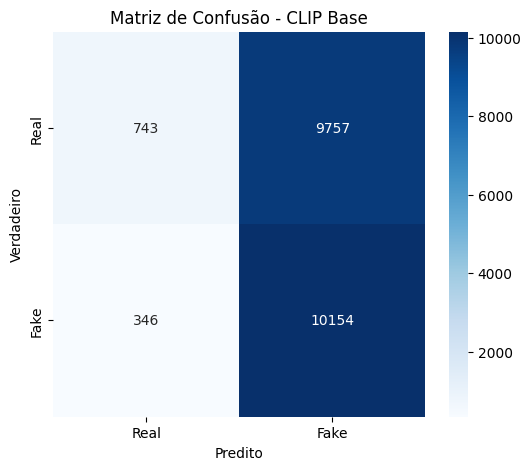


🔄 Carregando Seu Fine-Tuning: /kaggle/working/modelo_final_unzipped ...
🚀 Rodando Inferência (Seu Fine-Tuning)...


  0%|          | 0/329 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb 


>>> RESULTADOS: CLIP Fine-Tuned
🏆 Acurácia: 97.85%
------------------------------
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98     10500
        Fake       0.98      0.98      0.98     10500

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



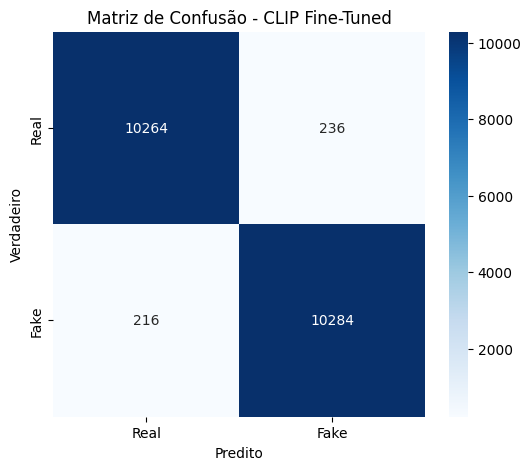

In [30]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import CLIPProcessor, CLIPModel
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

# --- CONFIGURAÇÕES ---
VAL_CSV = "validation_set_mixed.csv"
CLASSES = ["Real", "Fake"] # 0=Real, 1=Fake
PROMPTS = ["a real photograph", "an AI-generated image"] # Textos que o CLIP vai comparar

# Caminhos dos modelos
MODEL_BASE = "openai/clip-vit-base-patch16"
MODEL_TUNED = "/kaggle/working/modelo_final_unzipped" # Ou a pasta final se salvou lá

BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"📊 Preparando Validação Comparativa...")

# 1. Carregar Dados
val_df = pd.read_csv(VAL_CSV)
# Importante: Usamos aug_prob=0.0 para validar na imagem ORIGINAL (sem estragar)
# Queremos saber se ele funciona no mundo real, não na simulação
val_dataset = RobustCLIPDataset(val_df, processor, aug_prob=0.0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Gabarito (Ground Truth)
y_true = val_df['target'].values

def predict_with_model(model_path, loader, name):
    print(f"\n🔄 Carregando {name}: {model_path} ...")
    try:
        model = CLIPModel.from_pretrained(model_path).to(DEVICE)
        processor = CLIPProcessor.from_pretrained(model_path)
        model.eval()
    except Exception as e:
        print(f"❌ Erro ao carregar {name}: {e}")
        return None

    # Prepara os textos de classificação (Zero-Shot Classifier)
    text_inputs = processor(text=PROMPTS, return_tensors="pt", padding=True).to(DEVICE)
    
    preds = []
    
    print(f"🚀 Rodando Inferência ({name})...")
    with torch.no_grad():
        for batch in tqdm(loader):
            # Pega só as imagens do batch
            pixel_values = batch["pixel_values"].to(DEVICE)
            
            # O modelo compara as imagens com os 2 textos (Real vs Fake)
            outputs = model(
                pixel_values=pixel_values,
                input_ids=text_inputs.input_ids,
                attention_mask=text_inputs.attention_mask,
                return_loss=False
            )
            
            # Pega a probabilidade maior (0 ou 1)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            batch_preds = torch.argmax(probs, dim=1).cpu().numpy()
            
            preds.extend(batch_preds)
            
    return preds

def show_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n>>> RESULTADOS: {name}")
    print(f"🏆 Acurácia: {acc:.2%}")
    print("-" * 30)
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    # Plot Matriz de Confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f"Matriz de Confusão - {name}")
    plt.ylabel("Verdadeiro")
    plt.xlabel("Predito")
    plt.show()

# --- EXECUÇÃO ---

# 1. Avaliar Modelo Base (OpenAI)
preds_base = predict_with_model(MODEL_BASE, val_loader, "CLIP Base (OpenAI)")
if preds_base:
    show_metrics(y_true, preds_base, "CLIP Base")

# 2. Avaliar Seu Modelo (Fine-Tuned)
# Verifica se a pasta existe antes
import os
if os.path.exists(MODEL_TUNED):
    preds_tuned = predict_with_model(MODEL_TUNED, val_loader, "Seu Fine-Tuning")
    if preds_tuned:
        show_metrics(y_true, preds_tuned, "CLIP Fine-Tuned")
else:
    print(f"⚠️ Modelo tunado não encontrado em {MODEL_TUNED}. Verifique o caminho.")